# Forward modeling of an observed spectrum using the Bayesian framework available in SEDA

Compare the Sonora Elf Owl models to a near-infrared spectrum for a late-T brown dwarf (~750 K)

In [1]:
from astropy.io import fits, ascii
import seda # import the seda package
from dynesty import plotting as dyplot # to plot nested sampling results
import importlib
import numpy as np
import pickle


    SEDA package imported


Read the near-infrared spectrum from IRTF/SpeX for the T8 brown dwarf 2MASS J04151954-0935066 in Burgasser et al. (2004)

In [2]:
# SpeX spectrum
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read input data

In [3]:
# input spectrum
wl_spectra = wl_SpeX
flux_spectra = flux_SpeX
eflux_spectra = eflux_SpeX
res = 100 # spectral resolution of input spectrum to convolve model spectra
lam_res = 2.0 # (um) reference wavelength to get the above resolution for model spectra
d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, distance=d_target, 
                         eflux_spectra=eflux_spectra, res=res, lam_res=lam_res)


   Input data loaded successfully


Read model grid options

In [4]:
model = 'Sonora_Elf_Owl'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_700.0_800.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_850.0_950.0/',             
            ] # all spectra in the indicated folders (and meeting the criteria below) will be used

Teff_range = np.array((700, 900)) # Teff range
logg_range = np.array((4.0, 5.0)) # logg range
R_range = np.array((0.6, 1.0)) # Rjup

my_model = seda.ModelOptions(model=model, model_dir=model_dir, logg_range=logg_range, 
                             Teff_range=Teff_range, R_range=R_range)


   Model options loaded successfully


Read Bayes fit options

In [5]:
my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model)#, dynamic_sampling=False)


      3000 model spectra selected with Teff=[700, 900] and logg=[4.0, 5.0]


Reading model grid:   0%|          | 0/3000 [00:00<?, ?it/s]

      elapsed time: 31.0 s

   Bayes fit options loaded successfully


Run the nested sampling

In [7]:
out_bayes = seda.bayes(my_bayes)


   Estimate Bayesian posteriors

      Uniform priors:
         Teff range = [700 900]
         logg range = [4. 5.]
         logKzz range = [2. 9.]
         Z range = [-1.  1.]
         CtoO range = [0.5 2.5]
         R range = [0.6 1. ]


   Starting dynesty...


25242it [8:39:59,  1.24s/it, batch: 4 | bound: 29 | nc: 1 | ncall: 182971 | eff(%): 13.709 | loglstar: 10057.050 < 10063.583 < 10062.059 | logz: 10030.692 +/-  0.190 | stop:  0.987]       

      Bayesian sampling results saved successfully

   Bayesian sampling ran successfully
      elapsed time: 8.7 hr


# Plot posteriors

Read the output from the nested sampling to make plots

(it is not necessary if the bayesian output, out_bayes, is already in memory)

In [7]:
# open the file in binary mode
with open(my_bayes.bayes_pickle_file, 'rb') as file:
    # deserialize and retrieve the variable from the file
    out_bayes = pickle.load(file)

print('Posteriors loaded successfully')

Posteriors loaded successfully


Make corner plot using dynesty tools

Quantiles:
Teff (K) [(0.025, 760.0462533815362), (0.5, 761.1437080707065), (0.975, 762.2631600048345)]
Quantiles:
logg [(0.025, 4.523015134536752), (0.5, 4.532046010578428), (0.975, 4.5410896516752866)]
Quantiles:
logKzz [(0.025, 3.959772642700761), (0.5, 3.9927978784888363), (0.975, 4.000523089591102)]
Quantiles:
Z [(0.025, 0.08365275733769248), (0.5, 0.08809422222334914), (0.975, 0.09267159684184217)]
Quantiles:
C/O [(0.025, 1.1263311545030383), (0.5, 1.1350458099626581), (0.975, 1.1435747086504013)]
Quantiles:
R (Rj) [(0.025, 0.7808809875128945), (0.5, 0.7838559490535266), (0.975, 0.786802473357624)]


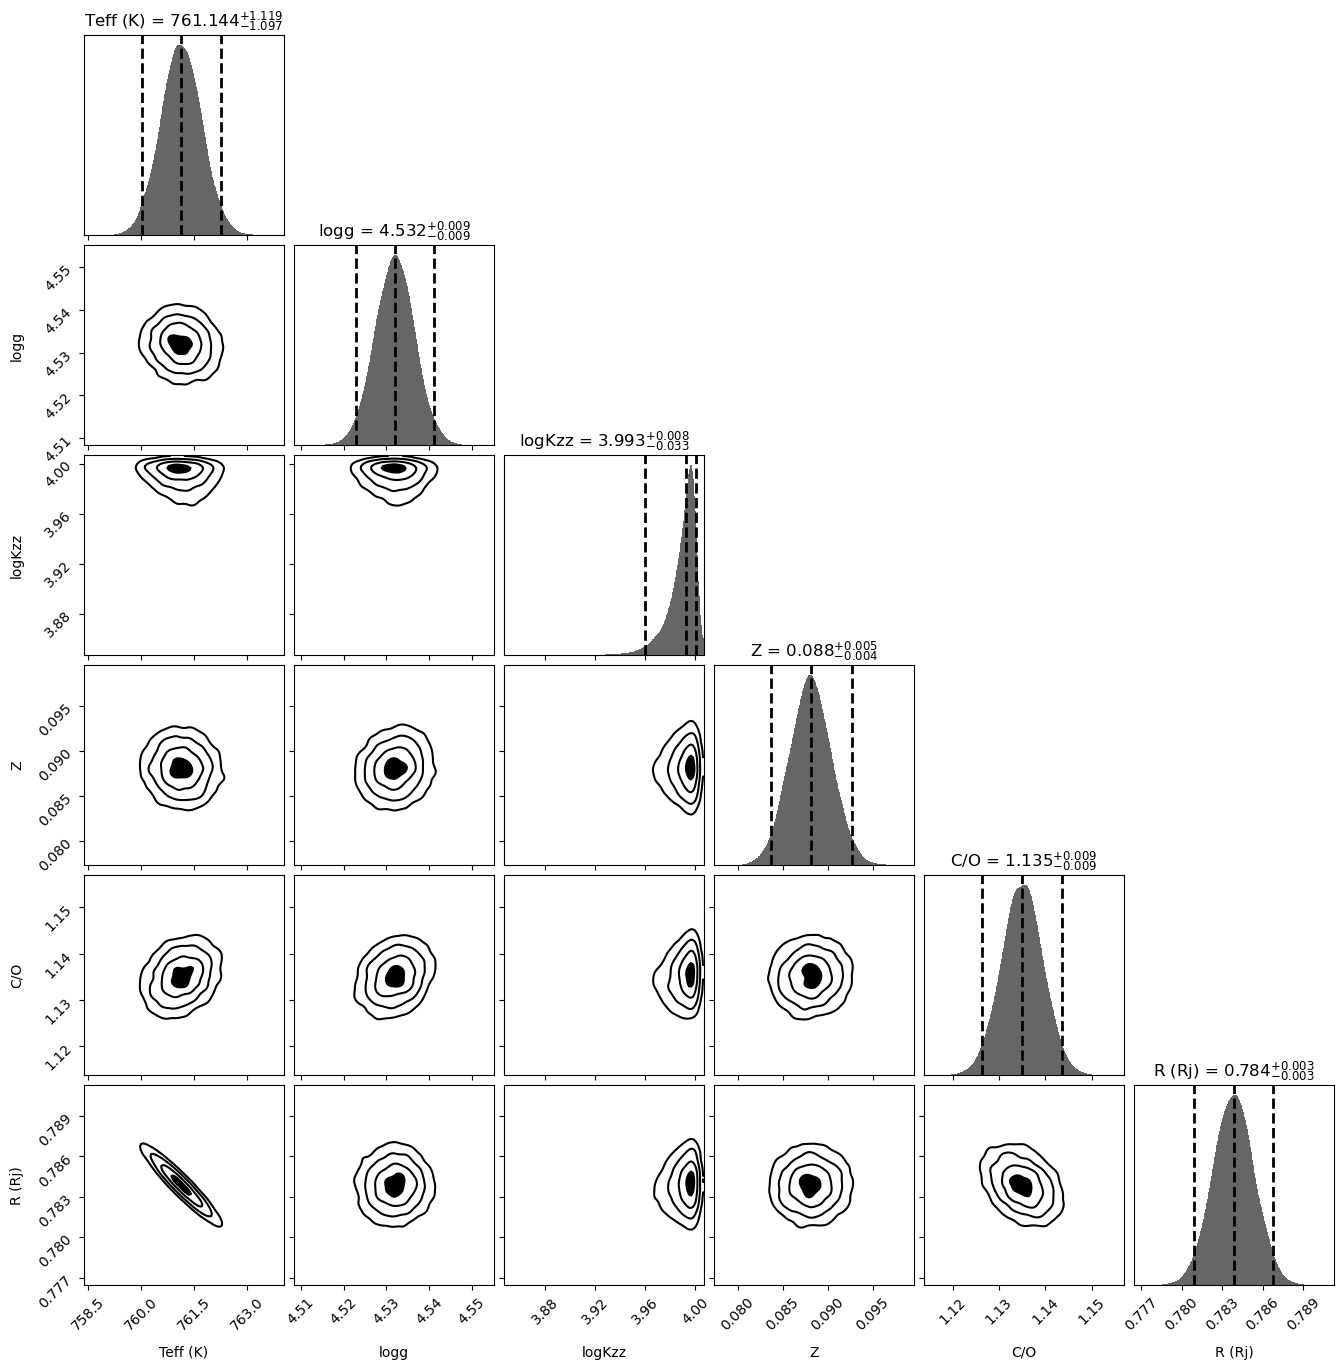

In [8]:
# plot the 2-D marginalized posteriors.
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(out_bayes['out_dynesty'], show_titles=True, verbose='true', 
                              title_fmt='.3f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)

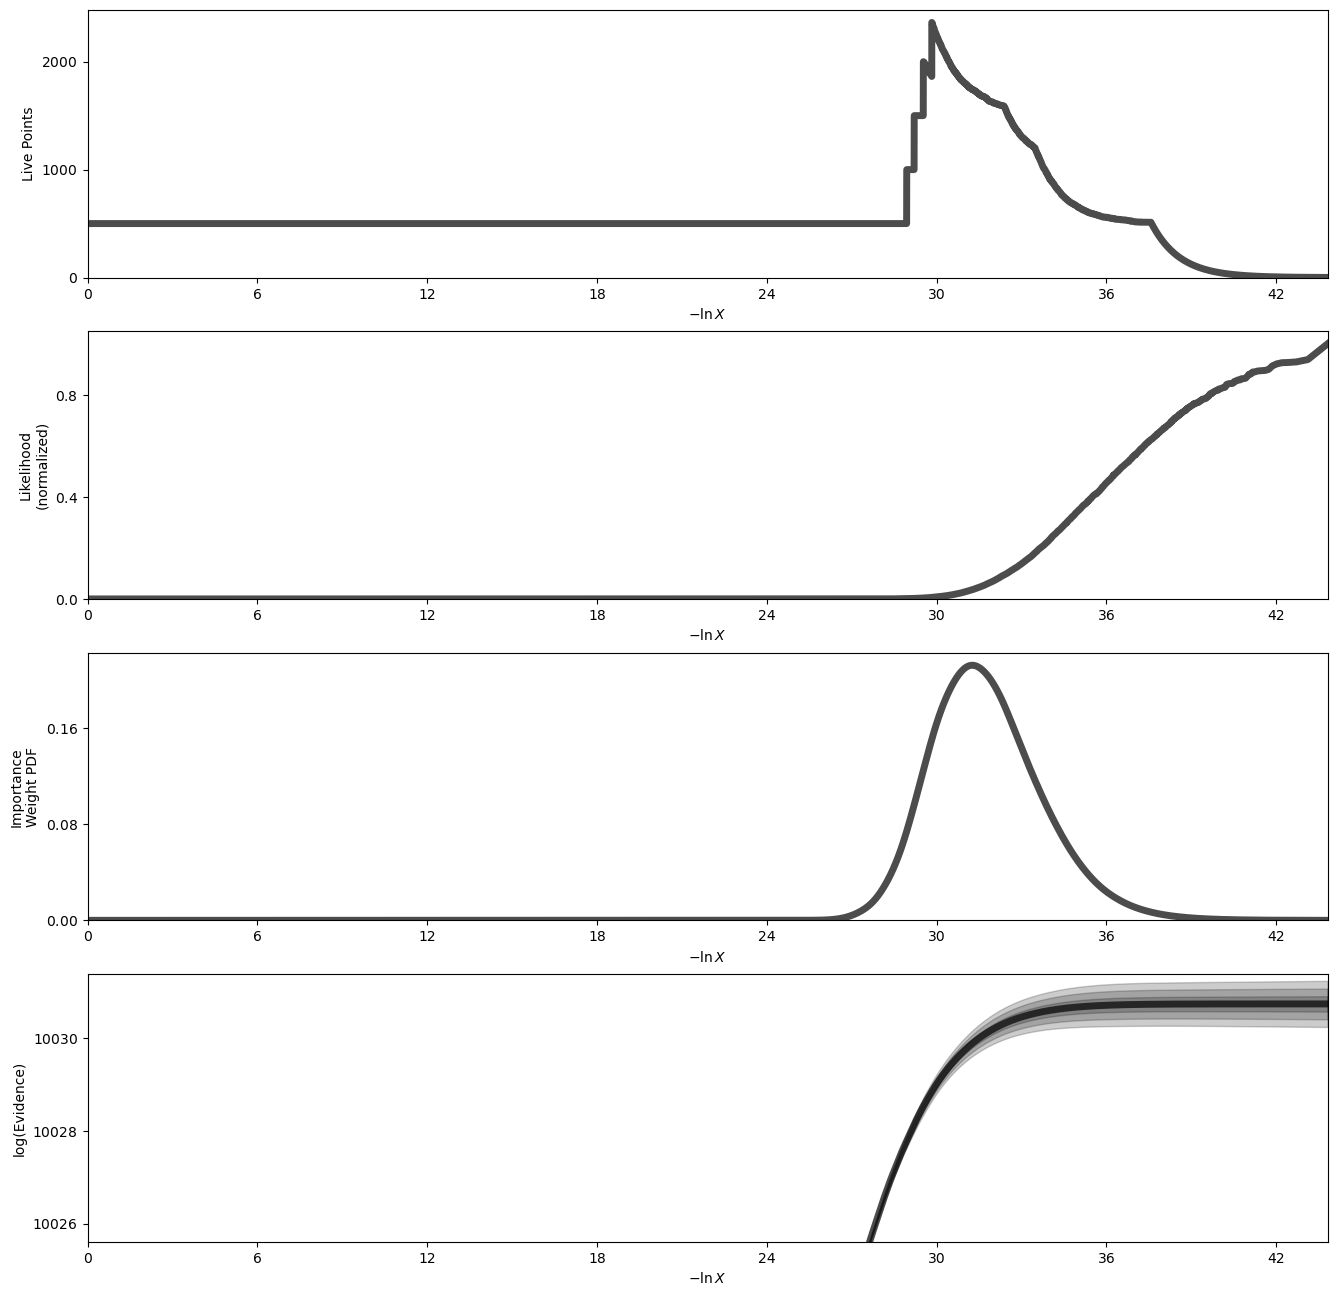

In [10]:
# plot a summary of the run

fig, axes = dyplot.runplot(out_bayes['out_dynesty'], color='black', mark_final_live=False, logplot=True)

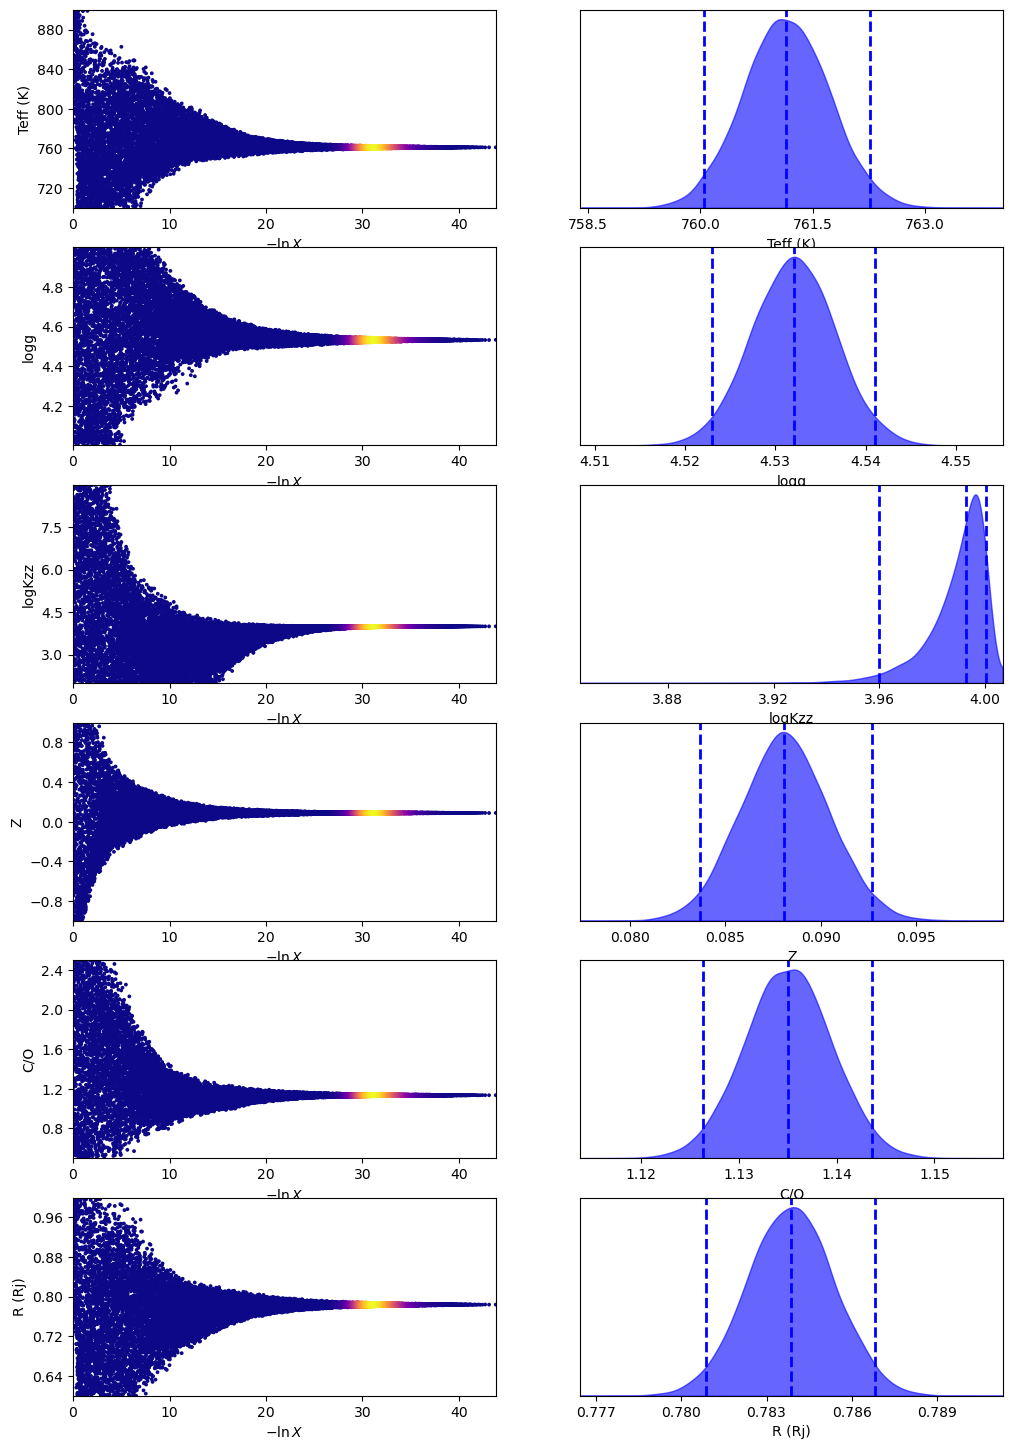

In [11]:
# plot traces and 1-D marginalized posteriors

fig, axes = dyplot.traceplot(out_bayes['out_dynesty'], labels=labels)

# Plot model spectrum from median posteriors

SED with the best model fit from the Bayesian sampling.

The pickle file generated by seda.bayes_fit and stored with the name my_bayes.bayes_pickle_file is the input file to make plots.

It needs to read a model grid subset around the median posteriors to generate the best model fit.


      480 model spectra selected with Teff=[750.0, 800.0] and logg=[4.5, 4.75]


Reading model grid:   0%|          | 0/480 [00:00<?, ?it/s]

      elapsed time: 8.0 s


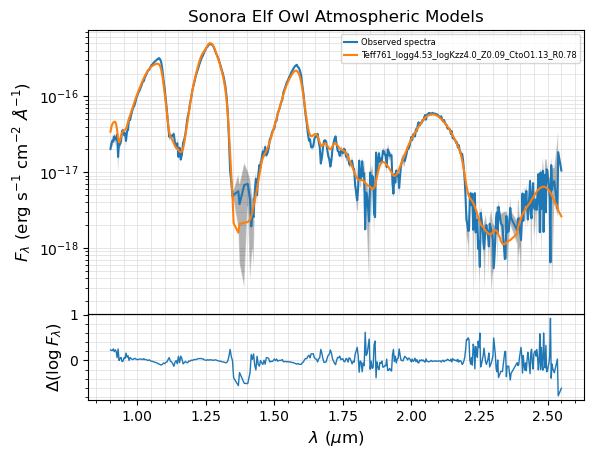

In [11]:
# using default logarithmic scale for fluxes
seda.plot_bayes_fit(my_bayes.bayes_pickle_file)


      480 model spectra selected with Teff=[750.0, 800.0] and logg=[4.5, 4.75]


Reading model grid:   0%|          | 0/480 [00:00<?, ?it/s]

      elapsed time: 8.0 s


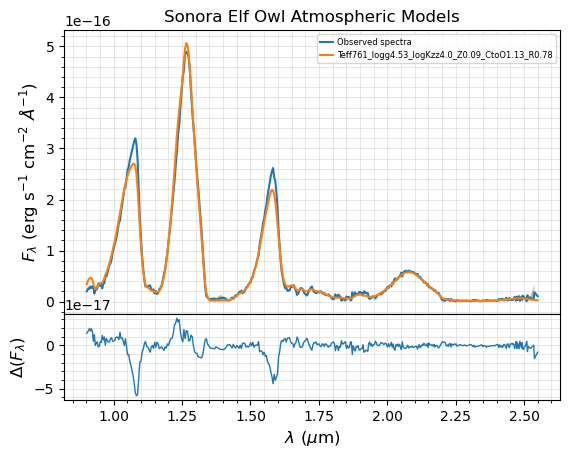

In [12]:
# considering fluxes in linear scale
seda.plot_bayes_fit(my_bayes.bayes_pickle_file, ylog=False)